# PyBlastAfterglow | GRB afterglow | tophat jet

## Setup and run

1. Set the working directory, where model output will be saved. 
__Important__: do not use the same folder for multiple runs. H5 library will try to override the file and fail, if the file is loaded somewhere. 
2. Set jet properties (initial Energy, lorentz factor, opening engle, etc. of he jet)
3. Set simulation parameters and settings
4. Run the simulation
5. Analyze the result

---

In [1]:
import copy, os, gc, h5py, numpy as np, matplotlib.pyplot as plt
import PyBlastAfterglowMag as pba
from PyBlastAfterglowMag.wrappers import run_grb
from PyBlastAfterglowMag.utils import cgs
from IPython.display import clear_output

## Running top-hat jet 

Tophat jet with forward shock (FS) only needs 8 free parameters:
- [ Eiso_c, Gamma0c, theta_w, n_ism, theta_obs, eps_e_fs, eps_b_fs, p_fs ]

In [2]:
# Define jet structure (analytic; tophat) -- 3 free parameters 
struct = dict(
    struct="tophat", # type of the structure tophat or gaussian
    Eiso_c=1.e53,    # isotropic equivalent energy of the burst 
    Gamma0c=400.,    # lorentz factor of the core of the jet 
    M0c=-1.,         # mass of the ejecta (if -1 -- iferr from Eiso_c and Gamma0c)
    theta_c=0.1,     # half-opening angle of the core of the jet
    theta_w=0.1      # half-opening angle of the winds of the jet
)

# set model parameters
P = dict(
        # main model parameters; Uniform ISM -- 2 free parameters
        main=dict(
            n_ism=1.,    # ISM density (assuming uniform)
            theta_obs=0, # observer angle (from pol to jet axis)  
            tb0=3e3,     # time in the burster frame where simulation starts
            ntb=1000,    # number of timesteps for blastwave evolution (simulation resolution)
            rtol=5e-7,   # relative tolerance for adaptive quadrature that compute observed emission
            lc_freqs='array logspace 1e8 1e29 96', # frequencies for light curve calculation
            lc_times='array logspace 3e3 1e10 128' # times for light curve calculation
        ),
        # ejecta parameters; FS only -- 3 free parameters 
        grb=dict(
            structure=struct, # structure of the ejecta
            eps_e_fs=0.1,     # microphysics - FS - frac. energy in electrons
            eps_b_fs=0.001,   # microphysics - FS - frac. energy in magnetic fields
            p_fs=2.2,         # microphysics - FS - slope of the injection electron spectrum
            do_lc='yes',      # task - compute light curves
        )
)


# code needs a working directory where to save initial data & final results
working_dir = os.getcwd() + '/tmp/' # default working directory

# run the code and get the instance of a python interfact to the code intput/output 
pba_run = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

# Analyze results of the run

/tmp/ipykernel_46057/3313287531.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale('log')
/tmp/ipykernel_46057/3313287531.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[i].set_ylim(1e-7*np.max(lc), 10*np.max(lc))


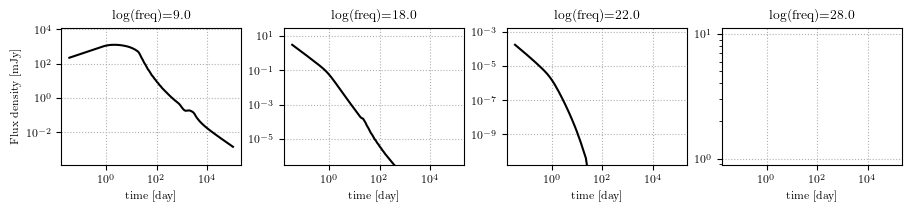

In [12]:
# plot light curves
def plot_lcs(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None, freqs:tuple):
    # get light curves
    times = ejecta.get_lc_times()
    # freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(freqs),figsize=(9,2),layout='constrained')
    for i, freq in enumerate(freqs):
        lc = ejecta.get_lc(freq=freq)
        axes[i].plot(times/cgs.day, lc,color='black')
        if not ejecta_def is None:
            lc = ejecta_def.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='gray',ls=':' )
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-7*np.max(lc), 10*np.max(lc))
        axes[i].set_title(f"log(freq)={np.log10(freq)}")
        axes[i].set_xlabel("time [day]")
        axes[i].grid(ls=':')
    axes[0].set_ylabel("Flux density [mJy]")
    plt.show()
plot_lcs(ejecta=pba_run.GRB, ejecta_def=None, freqs=(1e9, 1e18, 1e22, 1e28))

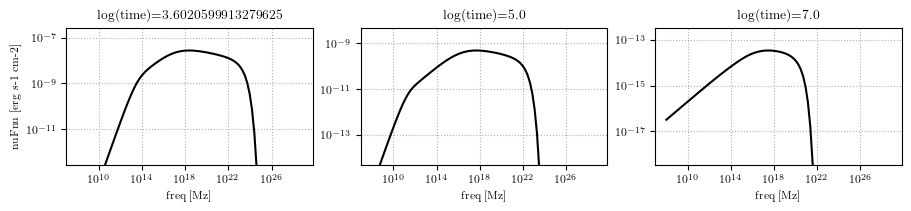

In [5]:
def plot_spectra(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None,times:tuple):
    # get light curves
    # times = ejecta.get_lc_times()
    freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(times),figsize=(9,2),layout='constrained')
    for i, time in enumerate(times):
        spec = ejecta.get_lc(time=time)
        spec = freqs*spec*1e-3*1e-23
        axes[i].plot(freqs, spec,color='black')
        if not ejecta_def is None:
            spec = ejecta_def.get_lc(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='gray',ls=':' )
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-5*np.max(spec), 10*np.max(spec))
        axes[i].set_title(f"log(time)={np.log10(time)}")
        axes[i].set_xlabel("freq [Mz]")
        axes[i].grid(ls=':')
    axes[0].set_ylabel("nuFnu [erg s-1 cm-2]")
    plt.show()
plot_spectra(ejecta=pba_run.GRB,ejecta_def=None,times=(4e3, 1e5, 1e7))

# VHE lightcurves and spectra
Let's consider including synchrotron self-compton and pp-process. 

Run is more computationally expensive. Takes about ~3 minutes.

In [6]:
P_ssc=copy.deepcopy(P)
P_ssc["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_ssc["grb"]["method_pp_fs"] = "numeric" # from none -> numeric
working_dir = os.getcwd() + '/tmp_ssc/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_ssc = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_ssc,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

/tmp/ipykernel_46057/2309319719.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[i].set_ylim(1e-7*np.max(lc), np.max(lc))


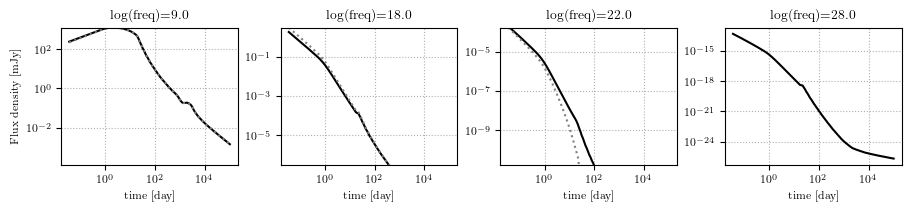

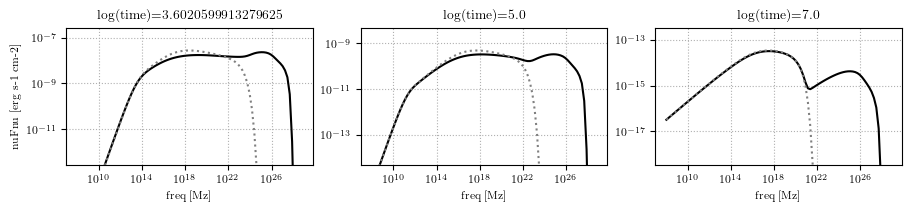

In [8]:
plot_lcs(ejecta=pba_run_ssc.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28))
plot_spectra(ejecta=pba_run_ssc.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7))

# Radio/Optical emission fron Forward & Reverse shocks

In [9]:
P_fsrs=copy.deepcopy(P)
P_fsrs["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs["grb"]["bw_type"] = "fsrs" # from none -> numeric

P_fsrs["grb"]["eps_e_rs"] = 0.1
P_fsrs["grb"]["eps_b_rs"] = 0.01
P_fsrs["grb"]["p_rs"] = 2.2

working_dir = os.getcwd() + '/tmp_fsrs/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

/tmp/ipykernel_46057/3313287531.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale('log')
/tmp/ipykernel_46057/3313287531.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[i].set_ylim(1e-7*np.max(lc), 10*np.max(lc))


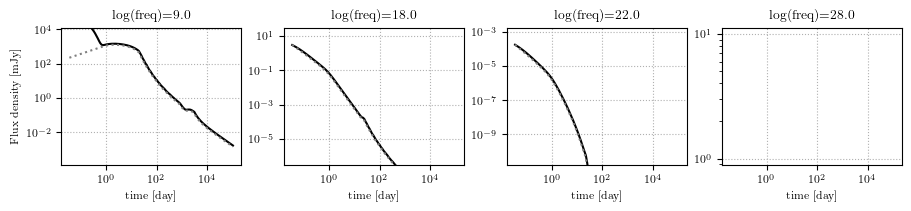

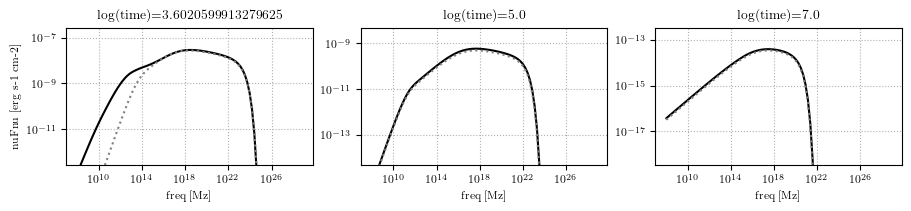

In [13]:
plot_lcs(ejecta=pba_run_fsrs.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28))
plot_spectra(ejecta=pba_run_fsrs.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7))

# FS & RS with VHE (complete run)

- Dynamics is affected by RS  
- FS and RS synchrotron radaition are computed
- SSC for FS is computed 

Long runs >10 minutes

In [14]:
P_fsrs_ssc=copy.deepcopy(P)

P_fsrs_ssc["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_fsrs_ssc["grb"]["method_pp_fs"] = "numeric" # from none -> numeric

P_fsrs_ssc["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs_ssc["grb"]["bw_type"] = "fsrs" # from none -> numeric

P_fsrs_ssc["grb"]["eps_e_rs"] = 0.1
P_fsrs_ssc["grb"]["eps_b_rs"] = 0.01
P_fsrs_ssc["grb"]["p_rs"] = 2.2

working_dir = os.getcwd() + '/tmp_fsrs_ssc/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs_ssc = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs_ssc,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

/tmp/ipykernel_46057/3313287531.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[i].set_ylim(1e-7*np.max(lc), 10*np.max(lc))


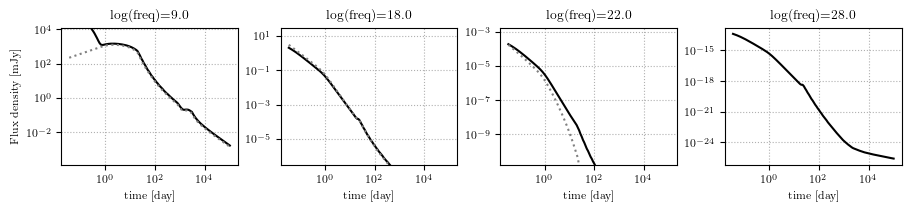

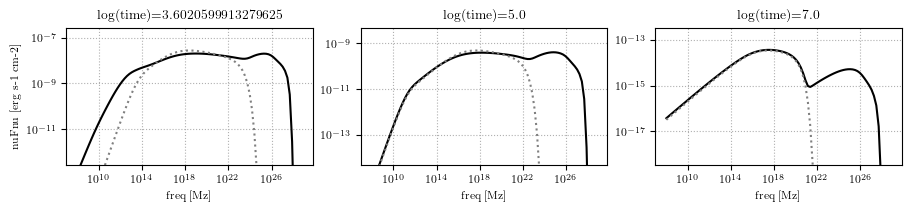

In [15]:
plot_lcs(ejecta=pba_run_fsrs_ssc.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28))
plot_spectra(ejecta=pba_run_fsrs_ssc.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7))